In [1]:
%matplotlib inline


import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import os
import pandas as pd

from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from nilearn import plotting
from nilearn import image
from nilearn.connectome import ConnectivityMeasure

import nibabel as nib

import warnings
warnings.filterwarnings("ignore")

/data/local/softwares/anaconda3/envs/psycnet/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/data/local/softwares/anaconda3/envs/psycnet/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/data/local/softwares/anaconda3/envs/psycnet/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
def get_subjectinfo(data_dir='/data_remote/ABIDE/', file='Phenotypic'):
    """
    :param file: csv file containing subject information
    :return: dictionary with relevant key/value pairs
    """

    COI_ABIDEI = ['SITE_ID', 'SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN', 'SEX']
    COI_ABIDEII = ['SITE_ID', 'SUB_ID', 'DX_GROUP', 'AGE_AT_SCAN ', 'SEX'] # Notice space after AGE_AT_SCAN

    pheno_file = file + "_ABIDE_I.csv"
    pheno_ABIDEI = pd.read_csv(osp.join(data_dir, pheno_file), 
                               dtype={'SITE_ID':str, 'SUB_ID':int, 'DX_GROUP':int, 'AGE_AT_SCAN':float, 'SEX':str})[COI_ABIDEI]
    pheno_ABIDEI['ABIDE_I_or_II'] = pd.Series(np.ones(len(pheno_ABIDEI))).astype(int)

    pheno_file = file + "_ABIDE_II.csv"
    pheno_ABIDEII = pd.read_csv(osp.join(data_dir, pheno_file), encoding='cp1252',
                               dtype={'SITE_ID':str, 'SUB_ID':int, 'DX_GROUP':int, 'AGE_AT_SCAN':float, 'SEX':int})[COI_ABIDEII]
    pheno_ABIDEII['ABIDE_I_or_II'] = pd.Series(2*np.ones(len(pheno_ABIDEII))).astype(int)

    pheno_ABIDEII.rename(columns = {'AGE_AT_SCAN ':'AGE_AT_SCAN'}, inplace=True) # change column name to take out stupid space   
    
    pheno = pd.concat([pheno_ABIDEI, pheno_ABIDEII], ignore_index=True)
    pheno['DX_GROUP'] = pheno['DX_GROUP']-1 # so that 0-> ASD, 1->CON
    
    return pheno


In [3]:
# Create a csv file (Pandas Dataframe) for further machine learning

def create_ml_csv(T1_file=None, 
                  nuisance_file='RS_denoise/nuisance_mat_18', 
                  input_root_dir='/data_local/deeplearning/ABIDE_LC',
                  output_root_dir='/data_local/deeplearning/ABIDE_ML_inputs',
                  sbc_dir = 'sbc',
                  subject_list_file='list_2169'):
    
    '''
    subject_list_file: a file with a list of subject ids
    root_dir: root directory with imaging and nuisance data
    img_file: rsfmri file
    T1_file: T1 scan file
    nuisance_file: confounds (motion etc.,)
    '''
    
    subject_list = pd.read_csv(osp.join(input_root_dir, subject_list_file), names=['SUB_ID'], header=None)
    subject_info = get_subjectinfo()
    
    df_data_info = subject_info.merge(subject_list, on='SUB_ID')
    df_data_info['SUB_ID'] = np.loadtxt(osp.join(input_root_dir, subject_list_file), dtype='str') # easier to get '00' prefix
    #data_columns = ['ids', 'labels', 'tr', 'rsfmri', 't1', 'nuisance']
    
    rsfmri_bptf_file_list = []
    rsfmri_nonbptf_file_list = []
    nuisance_file_list = []
    TR_list = []
    nT_list = []
    
    #outputs
    sbc_file_list = [] # seed_based filenames
    
    # Check if output directory exists
    if not osp.exists(output_root_dir):
        os.makedirs(output_root_dir)
        
    
    for sub_i in df_data_info['SUB_ID']:
        rsfmri_bptf_file = osp.join(input_root_dir, 'raw', sub_i, 'RS_denoise/RS_clean_bptf_MNI.nii.gz')
        rsfmri_nonbptf_file = osp.join(input_root_dir, 'raw', sub_i, 'RS_denoise/RS_clean_MNI.nii.gz')
        
        hdr = nib.load(rsfmri_bptf_file).header
        
        TR_list.append(hdr.get_zooms()[3])
        nT_list.append(hdr.get_data_shape()[3])
        rsfmri_bptf_file_list.append(rsfmri_bptf_file)
        rsfmri_nonbptf_file_list.append(rsfmri_nonbptf_file)
        nuisance_file_list.append(osp.join(input_root_dir, 'raw', sub_i, nuisance_file))
        
        #outputs ATLAS->generic name that is a placeholder
        sbc_file_list.append(osp.join(output_root_dir, sub_i, time_course_dir, 'ATLAS/BPTF/CONFOUNDS/sbc_maps.npy'))
    

    df_data_info['RSFMRI_bptf_file'] = rsfmri_bptf_file_list
    df_data_info['RSFMRI_nonbptf_file'] = rsfmri_nonbptf_file_list
    df_data_info['TR'] = TR_list
    df_data_info['nTimes'] = nT_list
    df_data_info['nuisance_file'] = nuisance_file_list
    
    df_data_info['sbc_file'] = sbc_file_list
    
    return df_data_info


In [4]:
def select_atlas(atlas_name, atlas_dir='/data/rmthomas/nilearn_data'): # HO_cort_maxprob_thr25-2mm

    # Choose one of the atlases (add more when necessary)
    # 1. AAL
    # 2. HO_cort_maxprob_thr25-2mm


    # Check if valid atlas name
    if atlas_name not in ['AAL', 'HO_cort_maxprob_thr25-2mm', 'schaefer_100', 'schaefer_400',
                         'JAMA_IC19', 'JAMA_IC52', 'JAMA_IC7']:
        raise ValueError('atlas_name not found')

    if atlas_name == 'AAL':
        dataset = datasets.fetch_atlas_aal(version='SPM12')
        atlas_filename = dataset.maps
        labels = dataset.labels
        
    if atlas_name == 'HO_cort_maxprob_thr25-2mm':
        dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm')
        atlas_filename = dataset.maps
        labels = dataset.labels[1:] # the first element is background
        
        
    if atlas_name == 'schaefer_100':
        atlas_filename = osp.join(atlas_dir,'schaefer/Schaefer2018_100Parcels_17Networks_order_FSLMNI152_2mm.nii')
        labels = pd.read_csv(osp.join(atlas_dir, 
                                           'schaefer/Schaefer2018_100Parcels_17Networks_table.csv'))['label']
    if atlas_name == 'schaefer_400':
        atlas_filename = osp.join(atlas_dir, 
                                       'schaefer/Schaefer2018_400Parcels_17Networks_order_FSLMNI152_2mm.nii')
        labels = pd.read_csv(osp.join(atlas_dir, 
                                           'schaefer/Schaefer2018_400Parcels_17Networks_table.csv'))['label']
        
    if atlas_name == 'JAMA_IC19':
        atlas_filename = osp.join(atlas_dir, 'IC_JAMA/IC19.nii')
        labels =[f'JAMA_IC19_{i+1}' for i in range(19)]
    
    if atlas_name == 'JAMA_IC52':
        atlas_filename = osp.join(atlas_dir, 'IC_JAMA/IC52.nii')
        labels =[f'JAMA_IC52_{i+1}' for i in range(52)]
        
    if atlas_name == 'JAMA_IC7':
        atlas_filename = osp.join(atlas_dir, 'IC_JAMA/IC7.nii')
        labels =[f'JAMA_IC7_{i+1}' for i in range(7)]
        
    return  atlas_filename, labels, len(labels)
    #plotting.plot_roi(atlas_filename)

In [5]:
def bandpass(atlas_filename, to_bandpass = False, tr=1.0, low_freq=0.01, high_freq=0.001):
    if to_bandpass:
        masker = NiftiLabelsMasker(smoothing_fwhm=6, detrend=True, standardize=True, 
                                   t_r=tr, low_pass=low_freq, high_pass=high_freq, 
                                   memory='nilearn_cache', memory_level=1, verbose=0)
    else:
        masker = NiftiLabelsMasker(smoothing_fwhm=6, detrend=True, standardize=True, 
                                   memory='nilearn_cache', memory_level=1, verbose=0)
        
    return masker



In [ ]:
def get_sbc_maps(timecourses, brain_masker, func_filename, confound_filename):
    
    brain_time_series = brain_masker.fit_transform(func_filename,
                                               confounds=[confound_filename])
    
    sbc_maps = []
    for seed_time_series in timecourses:
        seed_based_correlations = np.dot(brain_time_series.T, seed_time_series) / seed_time_series.shape[0]
        seed_based_correlations_fisher_z = np.arctanh(seed_based_correlations)
        sbc_maps.append(np.squeeze(brain_masker.inverse_transform(seed_based_correlations_fisher_z.T).get_data()))
        
    return np.stack(sbc_maps)
        

In [9]:
def create_sbc_maps(atlas_names, bptf, confounds,
                    output_root_dir='/data_local/deeplearning/ABIDE_ML_inputs',
                    sbc_dir = 'sbc',
                    to_bandpass=False):

    
    df_data_info = create_ml_csv()
    
    # Write the generic input and output csv files
    df_data_info.to_csv(osp.join(output_root_dir, 'data_info.csv'))
    
    
    nsubjects = len(df_data_info)
    
    print_counter = 0
    
    brain_masker = bandpass(atlas_filename, to_bandpass=to_bandpass, tr=df_data_info['TR'].loc[sub_i])

    for sub_i in df_data_info.index:

        
        if print_counter%100 == 0:
            print(f'{sub_i}/{nsubjects}')
        nuisance = pd.read_csv(df_data_info['nuisance_file'].loc[sub_i], sep='\t', header=None)
        nuisance.to_csv('temp_nuisance.csv') # required for the next step in csv format

        for atlas_name in atlas_names:
            
            atlas_filename, labels, nrois = select_atlas(atlas_name)
                
            if bptf:
                
                rsfilename = df_data_info['RSFMRI_bptf_file'].loc[sub_i]
                
                if confounds:
                    atlas_bptf_conf_name = osp.join(atlas_name, 'bptf/nilearn_regress')
                    
                else:
                    atlas_bptf_conf_name = osp.join(atlas_name, 'bptf/no_nilearn_regress')
              
            else:
                
                rsfilename = df_data_info['RSFMRI_nobptf_file'].loc[sub_i]
                
                if confounds:
                    atlas_bptf_conf_name = osp.join(atlas_name, 'no_bptf/nilearn_regress')
                else:
                    atlas_bptf_conf_name = osp.join(atlas_name, 'no_bptf/no_nilearn_regress')
                    

            sbc_dir = osp.join(output_root_dir, df_data_info['SUB_ID'].loc[sub_i], 
                              sbc_dir, atlas_bptf_conf_name)
            
            if not osp.exists(sbc_dir):
                os.makedirs(sbc_dir)

            # Read timeseries as csv file
            tc_file = df_data_info['tc_file'].loc[sub_i].replace('ATLAS/BPTF/CONFOUNDS', atlas_bptf_conf_name)
            timecourses = pd.read_csv(tc_file).values.transpose() # resulting in nrois X ntimes matrix
            
            # Get sbc data 
            sbc_data = get_sbc_data(timecourses, brain_masker, rsfilename, nuisance)
            
            # Write seed based correlation maps
            sbc_file = df_data_info['sbc_file'].loc[sub_i].replace('ATLAS/BPTF/CONFOUNDS', atlas_bptf_conf_name)
            np.save(sbc_file, sbc_data)
            
            
            
        print_counter += 1

    return None

In [12]:
def run():
    
    #atlas_names=['JAMA_IC19', 'JAMA_IC52', 'JAMA_IC7', 'AAL', 'HO_cort_maxprob_thr25-2mm', 'schaefer_100', 'schaefer_400']
    atlas_names=['schaefer_100']

    output_root_dir='/data_local/deeplearning/ABIDE_ML_inputs'
    sbc_dir = 'sbc'
    
    for confs in [True, False]:
        create_sbc_maps(atlas_names, bptf=False, confounds=confs, 
                        output_root_dir=output_root_dir, sbc_dir=sbc_dir)
    

In [13]:
run()

0/2169
100/2169
200/2169
300/2169
400/2169
500/2169
600/2169
700/2169
800/2169
900/2169
1000/2169
1100/2169
1200/2169
1300/2169
1400/2169
1500/2169
1600/2169
1700/2169
1800/2169
1900/2169
2000/2169
2100/2169
0/2169
100/2169
200/2169
300/2169
400/2169
500/2169
600/2169
700/2169
800/2169
900/2169
1000/2169
1100/2169
1200/2169
1300/2169
1400/2169
1500/2169
1600/2169
1700/2169
1800/2169
1900/2169
2000/2169
2100/2169


In [ ]:
# Data exploration

df = create_ml_csv()
# plot ntimes to check what to include
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
df.hist(column='nTimes', bins=[50, 100, 125, 150, 200, 300, 500, 1000], ax=axes[0])
df.hist(column='nTimes', cumulative=-1, bins=[50, 100, 125, 150, 200, 300, 1000], linewidth=5, histtype='step', ax=axes[1])
#df_input_data['nTimes'].plot.kde()

In [3]:
# We will work with the first subject of the adhd data set.
# adhd_dataset.func is a list of filenames. We select the 1st (0-based)
# subject by indexing with [0]).

adhd_dataset = datasets.fetch_adhd(n_subjects=1)
func_filename = adhd_dataset.func[0]
confound_filename = adhd_dataset.confounds[0]



Dataset created in /data/rmthomas/nilearn_data/adhd



Downloaded 3072 of 3072 bytes (100.0%,    0.0s remaining) ...done. (3 seconds, 0 min)
Extracting data from /data/rmthomas/nilearn_data/adhd/74a52d3552145e11365bb68453d1a70c/adhd40_metadata.tgz..... done.


Downloaded 44414948 of 44414948 bytes (100.0%,    0.0s remaining) ...done. (98 seconds, 1 min)
Extracting data from /data/rmthomas/nilearn_data/adhd/26dc434877313cabfa02a4e93691edaf/adhd40_0010042.tgz..... done.


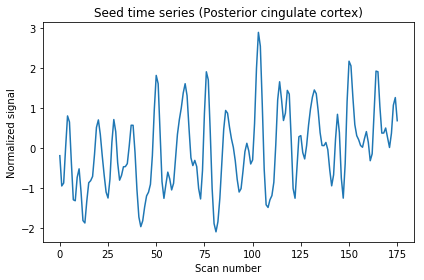

In [4]:
pcc_coords = [(0, -52, 18)]
from nilearn import input_data

seed_masker = input_data.NiftiSpheresMasker(
    pcc_coords, radius=8,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0)

seed_time_series = seed_masker.fit_transform(func_filename,
                                             confounds=[confound_filename])
brain_masker = input_data.NiftiMasker(
    smoothing_fwhm=6,
    detrend=True, standardize=True,
    low_pass=0.1, high_pass=0.01, t_r=2.,
    memory='nilearn_cache', memory_level=1, verbose=0)

plt.plot(seed_time_series)
plt.title('Seed time series (Posterior cingulate cortex)')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

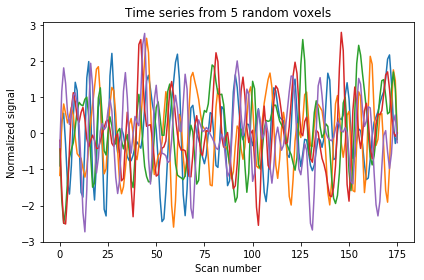

In [5]:
brain_time_series = brain_masker.fit_transform(func_filename,
                                               confounds=[confound_filename])

plt.plot(brain_time_series[:, [10, 45, 100, 5000, 10000]])
plt.title('Time series from 5 random voxels')
plt.xlabel('Scan number')
plt.ylabel('Normalized signal')
plt.tight_layout()

In [6]:
seed_based_correlations = np.dot(brain_time_series.T, seed_time_series) / \
                          seed_time_series.shape[0]
seed_based_correlations_fisher_z = np.arctanh(seed_based_correlations)
seed_based_correlation_img = brain_masker.inverse_transform(
    seed_based_correlations.T)

In [7]:
seed_based_correlation_img.shape

(61, 73, 61, 1)

In [8]:
seed_based_correlations_fisher_z.shape

(69681, 1)

In [9]:
seed_based_correlations.shape

(69681, 1)

In [47]:
x=[]
x.append(np.squeeze(seed_based_correlation_img.get_data()))
x.append(np.squeeze(seed_based_correlation_img.get_data()))
x.append(np.squeeze(seed_based_correlation_img.get_data()))

In [48]:
xx=np.stack(x)

In [49]:
xx.shape

(3, 61, 73, 61)